In [1]:
import tensorflow as tf
import re
from nltk.corpus import stopwords
import nltk
stop_words = stopwords.words('english')
from collections import defaultdict
import time
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from numpy.linalg import norm

/home/kapil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def text_processing(line):
    s=re.sub(r'<.+?>', '', line)
    s =re.sub("\d+", "", s)
    s=s.replace('@en .', '')
    s= re.sub(r'[\(\)\"\:\.\$\&\'\#\%\[\]\+\!\?\-\\]','',s)
    s=s.replace('\n','')
    s=s.replace(';','')
    s=re.sub(r"\b[a-zA-Z]\b", "", s)
    s=s.replace('u\2014',' ')
    s=re.sub(r'\([^)]*\)', '', s)
    return s

In [3]:
from gensim.models import Word2Vec

Words=[]
for line in lines:
    List1=[]
    line=text_processing(line)
    line=line.lower()
    for word in line.split('\t')[1].split():  
        word=re.sub(r"[^a-zA-Z]","",word)
        if word not in stop_words:
            List1.append(porter_stemmer.stem(word.rstrip()))
    Words.append(List1)


NameError: name 'lines' is not defined

In [ ]:
model = Word2Vec(Words)

In [ ]:
model.save("word2vec.model")

In [4]:
f=open('/home/kapil/Documents/IISc_sem/Machine_Learning_Large_Datasets/Assignment2/DBPedia.full/full_train.txt','r')
lines=f.readlines()

In [5]:
Titles=set()
total_ex=0
ex=0
for line in lines:
    line=line.lower()
    line=text_processing(line)
    for title in line.split('\t')[0].split(','):
        Titles.add(title.rstrip())
        total_ex+=1
    ex+=1

In [6]:
import numpy as np
print(total_ex)
print(ex)

298176
214997


In [7]:
b = dict(enumerate(Titles))
inv_map = {v: k for k, v in b.items()}        

In [ ]:
W=np.random.randn(100, 50)
Y=np.zeros((total_ex,50))
embedding=np.zeros((ex,100))
f=open('/home/kapil/Documents/IISc_sem/Machine_Learning_Large_Datasets/Assignment2/DBPedia.full/full_train.txt','r')
lines=f.readlines()
from progressbar import ProgressBar
pbar = ProgressBar()
start_time = time.time()
n=0
doc_count=0
for line in pbar(lines):
    Doc_rep=0
    count=0
    try:  
        line=text_processing(line).lower()
        for word in line.split('\t')[1].split():
            word=re.sub(r"[^a-zA-Z]","",word)
            if word not in stop_words:
                try:
                    Doc_rep+=model[porter_stemmer.stem(word.rstrip())]
                except KeyError:
                    continue
            count+=1
        emb=Doc_rep/count
        embedding[doc_count,0:100]=emb
        doc_count+=1
    except ZeroDivisionError:
        doc_count+=1
        continue
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.save(outfile, embedding)

In [8]:
import math

def sigmoid(x):
      return 1 / (1 + math.exp(-x))

In [9]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
model = Doc2Vec.load('my_doc2vec_model')

In [ ]:
def Cost_compute(mue,lmda,lines2,W):
    n=0
    Y=np.zeros((total_ex,50))
 ##   mue=0.0001
 ##   lmda=0.1
    l_c=0
    cost=np.zeros((50,1))
    update=np.zeros((50,100))
    phi=0
    p=0
    i=0
    start_time = time.time()
    for line1 in lines2:

        for title in line1.split('\t')[0].split(','):
            i=inv_map[text_processing(title).lower().rstrip()]
            phi=np.dot(W[i,:],embedding[l_c])
            p=sigmoid(phi)
            for k in range(50):
                if k==i:
                    cost[k]=cost[k]-np.log(p)+0.5*lmda*(norm(W[k,:]))
                    update[k,:]=update[k,:]+mue*(1-np.log(p))*embedding[l_c]
                else:
                    cost[k]=cost[k]-np.log(1-p)+0.5*lmda*(norm(W[k,:]))
                    update[k,:]=update[k,:]+mue*(-np.log(p))*embedding[l_c]
            
        l_c+=1
    print("--- %s seconds ---" % (time.time() - start_time))
    update=update/total_ex
    return cost,update

In [ ]:
num_epoch=5
W=np.random.uniform(low=-0.01, high=0.01, size=(50,100))
pbar1 = ProgressBar()
f=open('/home/kapil/Documents/IISc_sem/Machine_Learning_Large_Datasets/Assignment2/DBPedia.full/full_train.txt','r')
lines=f.readlines()
Loss=np.zeros((5,50))
for epoch in pbar1(range(num_epoch)):
    mue=0.0001
    lmda=0.1    
    cost,update=Cost_compute(mue,lmda,lines,W)
    for col in range(50):
        W[col,:]=W[col,:]*(1-mue*lmda)-mue*update[col,:]
        Loss[epoch,col]=cost[col]
    print("epoch %s" %(epoch))

In [ ]:
f=open('/home/kapil/Documents/IISc_sem/Machine_Learning_Large_Datasets/Assignment2/DBPedia.full/full_train.txt','r')
lines=f.readlines()
n=0
Y=np.zeros((total_ex,50))
 ##   mue=0.0001
 ##   lmda=0.1
Loss=np.zeros((epoch,50))
l_c=0
cost=np.zeros((50,1))
update=np.zeros((100,50))
phi=0
p=0
i=0
lmda=0.1
mue=0.0001
start_time = time.time()
for line1 in lines:

    for title in line1.split('\t')[0].split(','):
        i=inv_map[text_processing(title).lower().rstrip()]
        phi=np.dot(W[:,i],embedding[l_c])
        p=sigmoid(phi)
        for k in range(50):
            if k==i:
                cost[k]=cost[k]-np.log(p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(1-np.log(p))*embedding[l_c]
            else:
                cost[k]=cost[k]-np.log(1-p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(-np.log(p))*embedding[l_c]
            
    l_c+=1
print("--- %s seconds ---" % (time.time() - start_time))
update=update/total_ex
for col in range(50):
    W[col,:]=W[col,:]*(1-mue*lmda)-mue*np.transpose(update)[:,col]
    Loss[0,col]=cost[col]

In [ ]:
Loss=np.zeros((20,50))
for col in range(50):
    W[col,:]=W[col,:]*(1-mue*lmda)-mue*np.transpose(update)[:,col]
    #print(int(cost[col]))
    Loss[0, col]=int(cost[col])


In [ ]:
cost=np.zeros((50,1))
update=np.zeros((100,50))
phi=0
p=0
i=0
l_c=0
start_time = time.time()
for line1 in lines:

    for title in line1.split('\t')[0].split(','):
        i=inv_map[text_processing(title).lower().rstrip()]
        phi=np.dot(W[:,i],embedding[l_c])
        p=sigmoid(phi)
        for k in range(50):
            if k==i:
                cost[k]=cost[k]-np.log(p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(1-np.log(p))*embedding[l_c]
            else:
                cost[k]=cost[k]-np.log(1-p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(-np.log(p))*embedding[l_c]
            
    l_c+=1
print("--- %s seconds ---" % (time.time() - start_time))
update=update/total_ex

In [ ]:
for col in range(50):
    W[col,:]=W[col,:]*(1-mue*lmda)-mue*np.transpose(update)[:,col]
    Loss[1,col]=cost[col]

In [ ]:
print(Loss[0,:]-Loss[1,:])

In [ ]:
cost=np.zeros((50,1))
update=np.zeros((100,50))
phi=0
p=0
i=0
l_c=0
start_time = time.time()
from progressbar import ProgressBar
pbar9 = ProgressBar()
for line1 in pbar9(lines):

    for title in line1.split('\t')[0].split(','):
        i=inv_map[text_processing(title).lower().rstrip()]
        phi=np.dot(W[:,i],embedding[l_c])
        p=sigmoid(phi)
        for k in range(50):
            if k==i:
                cost[k]=cost[k]-np.log(p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(1-np.log(p))*embedding[l_c]
            else:
                cost[k]=cost[k]-np.log(1-p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(-np.log(p))*embedding[l_c]
            
    l_c+=1
print("--- %s seconds ---" % (time.time() - start_time))
update=update/total_ex

In [ ]:
for col in range(50):
    W[col,:]=W[col,:]*(1-mue*lmda)-mue*np.transpose(update)[:,col]
    Loss[2,col]=cost[col]

In [ ]:
print(Loss[1,:]-Loss[2,:])

In [ ]:
cost=np.zeros((50,1))
update=np.zeros((100,50))
phi=0
p=0
i=0
l_c=0
start_time = time.time()
for line1 in lines:

    for title in line1.split('\t')[0].split(','):
        i=inv_map[text_processing(title).lower().rstrip()]
        phi=np.dot(W[:,i],embedding[l_c])
        p=sigmoid(phi)
        for k in range(50):
            if k==i:
                cost[k]=cost[k]-np.log(p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(1-np.log(p))*embedding[l_c]
            else:
                cost[k]=cost[k]-np.log(1-p)+0.5*lmda*(norm(W[k,:]))
                update[:,k]=update[:,k]+mue*(-np.log(p))*embedding[l_c]
            
    l_c+=1
print("--- %s seconds ---" % (time.time() - start_time))
update=update/total_ex

In [ ]:
for col in range(50):
    W[col,:]=W[col,:]*(1-mue*lmda)-mue*np.transpose(update)[:,col]
    Loss[3,col]=cost[col]

In [ ]:
print(Loss[2,:]-Loss[3,:])

In [11]:
W=np.random.uniform(low=-0.1, high=0.1, size=(50,100))

In [ ]:
num_epoch=20
Loss=np.zeros((num_epoch,50))
from progressbar import ProgressBar
pbar8 = ProgressBar()
mue=0.1
lmda=0.1
emb=np.zeros((100,1))

for epoch in pbar8(range(num_epoch)):
    cost=np.zeros((50,1))
    update=np.zeros((100,50))
    phi=0
    p=0
    i=0
    l_c=0
    start_time = time.time()
    for line1 in lines:

        for title in line1.split('\t')[0].split(','):
            i=inv_map[text_processing(title).lower().rstrip()]
            emb=model.infer_vector(text_processing(line1.split('\t')[1]).lower())
            phi=np.dot(W[i,:],emb)
            p=sigmoid(phi)
            
            for k in range(50):
                if k==i:
                    cost[k]=cost[k]-np.log(p)+0.5*lmda*(norm(W[k,:]))
                    update[:,k]=update[:,k]+mue*(1-np.log(p))*emb
                else:
                    cost[k]=cost[k]-np.log(1-p)+0.5*lmda*(norm(W[k,:]))
                    update[:,k]=update[:,k]+mue*(-np.log(p))*emb
        l_c+=1
    print("--- %s seconds ---" % (time.time() - start_time))
    update=update/total_ex
    for col in range(50):
        W[col,:]=W[col,:]*(1-mue*lmda)-mue*np.transpose(update)[col,:]
        Loss[epoch,col]=cost[col]

--- 653.5938622951508 seconds ---


--- 627.0770602226257 seconds ---


--- 618.0890493392944 seconds ---


--- 616.6065905094147 seconds ---


--- 7465.775438308716 seconds ---


--- 666.6990025043488 seconds ---


--- 645.5036160945892 seconds ---


--- 771.8575282096863 seconds ---


--- 1053.3352346420288 seconds ---


[214935.91479838 214959.61663274 215154.31905202 215318.11643672
 214349.51234572 214879.25756229 215199.58113735 215059.05944405
 215170.91998618 214856.64383586 216035.08087073 215054.50245328
 215157.89764552 215040.39022819 215172.54419016 214751.64734668
 214669.7574524  215432.27118529 215107.51657005 215376.63438201
 215155.56085629 215222.50641959 214506.55305305 215122.44738755
 215519.99685514 214586.66184214 214860.53863018 215167.68055999
 215217.50990352 215126.89809125 215289.38897832 214258.15629212
 215597.52424561 214180.47882895 215314.19211062 214923.47842892
 215371.15321931 215573.62404001 215226.65706996 215002.78346899
 214700.63534272 214843.49791162 215134.84853337 214603.46396585
 214934.93144475 215272.40890504 215150.71175316 214399.42008994
 214603.695829   215416.52477528]


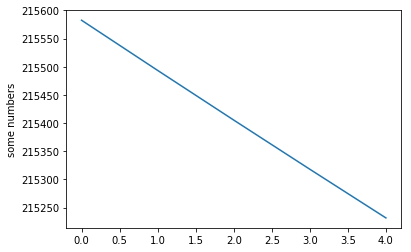

In [15]:
print(Loss[3,:])
import matplotlib.pyplot as plt
plt.plot(Loss[:,3])
plt.ylabel('some numbers')
plt.show()

In [ ]:
f=open('/home/kapil/Documents/IISc_sem/Machine_Learning_Large_Datasets/Assignment2/DBPedia.full/full_test.txt','r')
lines=f.readlines()
n1=0
correct=0
Y1=np.zeros((total_ex,50))
l=0
for line in lines:
    try:        
        line=text_processing(line).lower()
        for i in range(50):
            Y1[n1,:]=sigmoid(np.dot(W[i,:],embedding[l]))
        if b[list(Y1[n1,:]).index(max(list(Y1[n1,:])))] in line.split('\t')[0].split(','):
            correct+=1
        n1+=1
        l+=1   
    except ZeroDivisionError:
        continue

In [ ]:
print(correct/l)